### Classification Trees

In [1]:
# Importing the data
data <- read.csv('credit.csv')
dim(data)
head(data)

[1] 1000   17

checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no


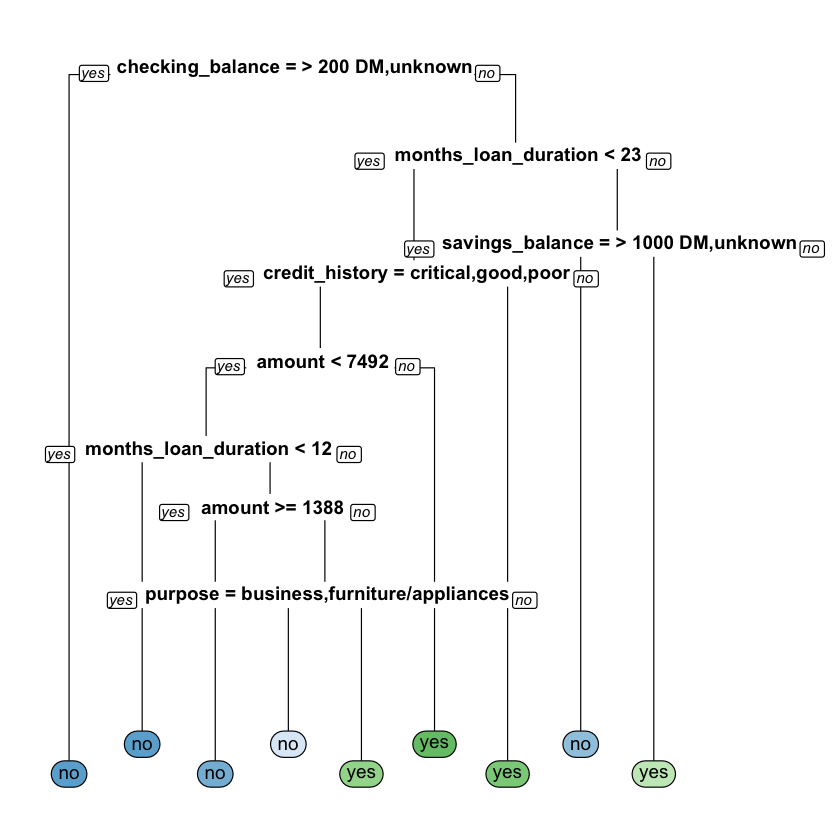

In [3]:
# Builing a classification tree
library(rpart)
library(rpart.plot)
credit_model <- rpart(formula = default ~ .,
                      data = data,
                      method = "class")
rpart.plot(x = credit_model, yesno = 2, type = 0, extra = 0)

In [5]:
# Train/Test split
train_indices <- sample(1:nrow(data), round(nrow(data) * 0.8))
train <- data[train_indices, ]
test <- data[-train_indices, ]
credit_model <- rpart(formula = default ~ ., data = train, method = "class")

In [8]:
# Confusion matrix
library(caret)
library(e1071)
class_prediction <- predict(object = credit_model, newdata = test, type = "class")
confusionMatrix(data = class_prediction, reference = test$default)

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  120  33
       yes  20  27
                                          
               Accuracy : 0.735           
                 95% CI : (0.6681, 0.7948)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.15789         
                                          
                  Kappa : 0.3274          
                                          
 Mcnemar's Test P-Value : 0.09929         
                                          
            Sensitivity : 0.8571          
            Specificity : 0.4500          
         Pos Pred Value : 0.7843          
         Neg Pred Value : 0.5745          
             Prevalence : 0.7000          
         Detection Rate : 0.6000          
   Detection Prevalence : 0.7650          
      Balanced Accuracy : 0.6536          
                                          
       'Positive' Class : no              
                              

In [11]:
# Compare models with a different splitting criterion
credit_model1 <- rpart(formula = default ~ ., data = train, method = "class", parms = list(split = "gini"))
credit_model2 <- rpart(formula = default ~ ., data = train, method = "class", parms = list(split = "information"))
pred1 <- predict(object = credit_model1, newdata = test, type = "class")
pred2 <- predict(object = credit_model2, newdata = test, type = "class")

# Comparing by calculation error
library(ModelMetrics)
ce(actual = test$default, predicted = pred1)
ce(actual = test$default, predicted = pred2)


Attaching package: ‘ModelMetrics’


The following objects are masked from ‘package:caret’:

    confusionMatrix, precision, recall, sensitivity, specificity


The following object is masked from ‘package:base’:

    kappa




[1] 0.265

[1] 0.26

### Regression Trees

In [12]:
# Importing the data
data2 <- read.csv("grade.csv")
dim(data2)
head(data2)

[1] 395   8

final_grade,age,address,studytime,schoolsup,famsup,paid,absences
3.0,18,U,2,yes,no,no,6
3.0,17,U,2,no,yes,no,4
5.0,15,U,2,yes,no,yes,10
7.5,15,U,3,no,yes,yes,2
5.0,16,U,2,no,yes,yes,4
7.5,16,U,2,no,yes,yes,10


In [14]:
# Splitting the data
assignment <- sample(1:3, size = nrow(data2),
                     prob = c(0.7, 0.15, 0.15), replace = TRUE)
grade_train <- data2[assignment == 1, ]    # Training indices
grade_valid <- data2[assignment == 2, ]    # Validation indices
grade_test  <- data2[assignment == 3, ]     # Test indices

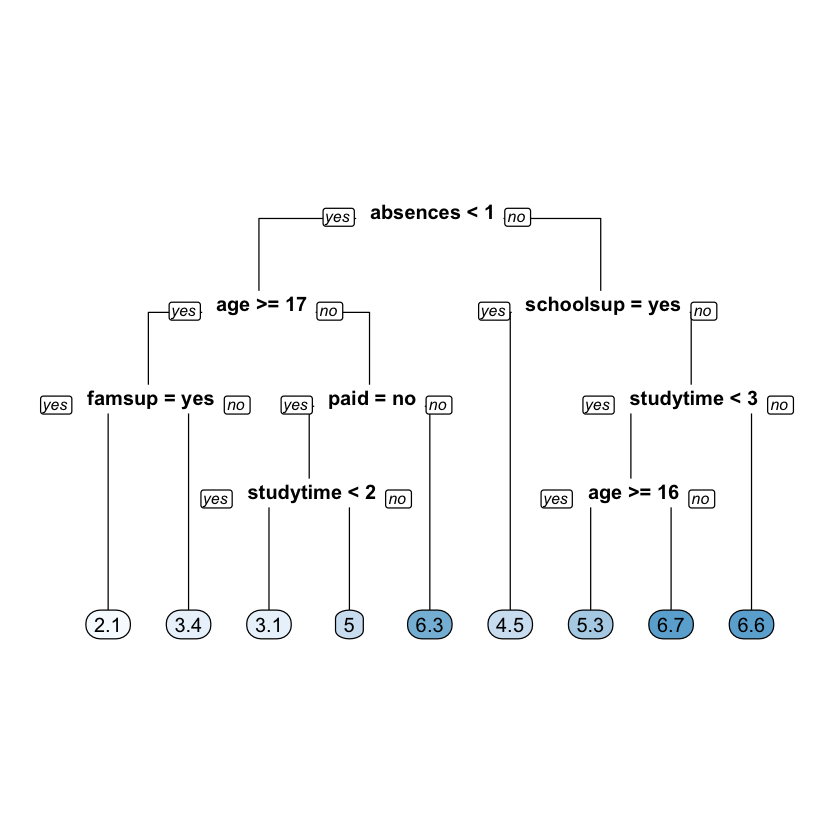

In [15]:
# Training a regression tree model
grade_model <- rpart(formula = final_grade ~ ., data = grade_train,
                     method = "anova")
rpart.plot(x = grade_model, yesno = 2, type = 0, extra = 0)

In [16]:
# Evaludating a regression tree model
pred <- predict(object = grade_model, newdata = grade_test)
rmse(actual = grade_test$final_grade, predicted = pred)

[1] 2.845241

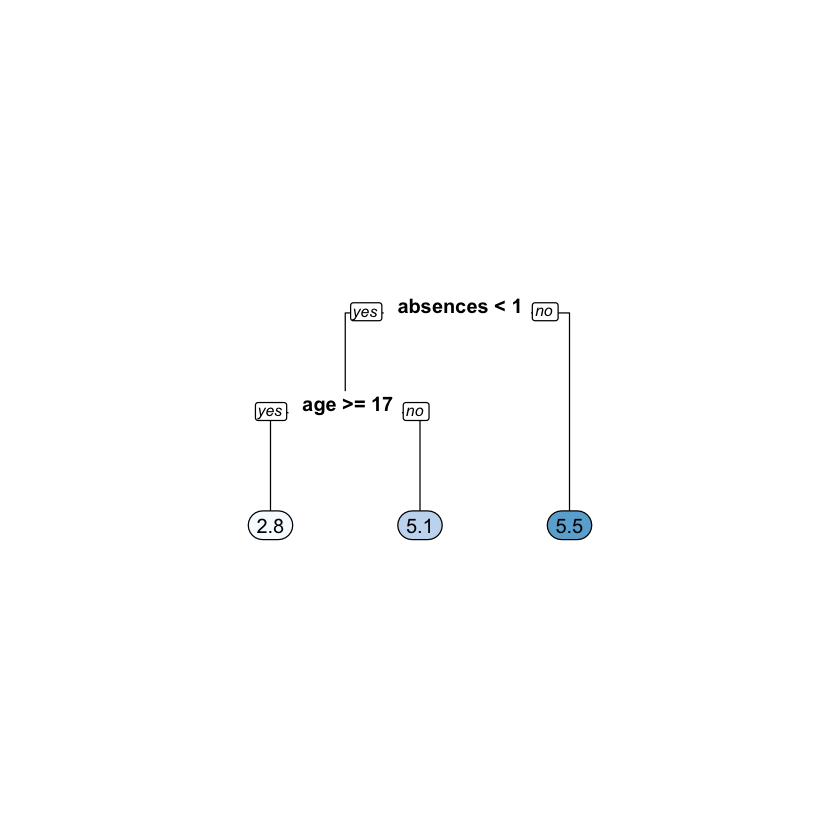

In [18]:
# Tuning the model
opt_index <- which.min(grade_model$cptable[, "xerror"])
cp_opt <- grade_model$cptable[opt_index, "CP"]
grade_model_opt <- prune(tree = grade_model, cp = cp_opt)
rpart.plot(x = grade_model_opt, yesno = 2, type = 0, extra = 0)

In [19]:
# Generate a grid of hyperparameter values
minsplit <- seq(1, 4, 1)
maxdepth <- seq(1, 6, 1)
hyper_grid <- expand.grid(minsplit = minsplit, maxdepth = maxdepth)

In [20]:
# Generate a grid of models
num_models <- nrow(hyper_grid)
grade_models <- list() # An empty list to store models
for (i in 1:num_models) {

        minsplit <- hyper_grid$minsplit[i]
        maxdepth <- hyper_grid$maxdepth[i]

        grade_models[[i]] <- rpart(formula = final_grade ~ ., 
                               data = grade_train, 
                               method = "anova",
                               minsplit = minsplit,
                               maxdepth = maxdepth)
}

In [21]:
# Evaluate the grid
num_models <- length(grade_models)
rmse_values <- c() # An empty vector to store RMSE values
for (i in 1:num_models) {

    model <- grade_models[[i]]
    
    pred <- predict(object = model,
                    newdata = grade_valid)
    
    rmse_values[i] <- rmse(actual = grade_valid$final_grade, 
                           predicted = pred)
}

best_model <- grade_models[[which.min(rmse_values)]]
pred <- predict(object = best_model, newdata = grade_test)
rmse(actual = grade_test$final_grade, predicted = pred)

[1] 2.740687